In [130]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch.optim as optim


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [131]:
path = 'C:/Users/thula/PR variational Encoders/lfw'

In [132]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [133]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


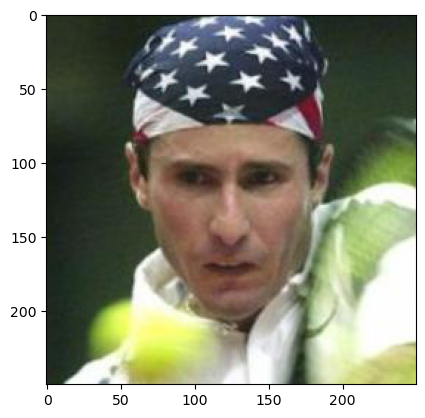

In [134]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

### Applications:
- **Autoencoders (AEs)** are primarily used for dimensionality reduction, denoising, and feature extraction. They are good at capturing the most relevant aspects of the data and can be used for data compression.
- **Variational Autoencoders (VAEs)** have all the applications of AEs but are particularly suited for generative tasks. They can generate new data instances that are not present in the training dataset by sampling from the learned latent distribution.

### Architecture:
- **Autoencoders** consist of two main parts: an encoder that compresses the input data into a lower-dimensional representation, and a decoder that reconstructs the input data from this representation. The representation is a deterministic, fixed-point encoding of the input data.
  
  In your AE code, the `encoder` and `decoder` are defined as sequences of layers that process the data through convolutions and transposed convolutions. There's a direct mapping from input to a latent representation and back to the reconstruction.

- **Variational Autoencoders** also have an encoder and a decoder, but the encoder outputs parameters (mean and log variance) of a proposed distribution over the latent space. A latent vector is then sampled from this distribution, introducing a stochastic element to the encoding.

  In your VAE code, the encoder outputs `mu` and `logvar`, from which `z` is sampled. This is a key distinction: the VAE introduces randomness through the `reparameterize` method, which uses `mu` and `logvar` to sample a latent vector `z`.

### Loss Function:
 **Autoencoders** typically use a simple loss function that measures the difference between the input and the output (reconstruction error), such as Mean Squared Error (MSE) or Binary Cross-Entropy.

 **Variational Autoencoders** the loss function for Variational Autoencoders (VAEs) consists of two main parts:

Reconstruction Loss: This component measures how well the VAE can reconstruct the input data from the latent representation. It ensures that the output resembles the original input. Mean Squared Error (MSE) is a common choice for continuous data.

Kullback-Leibler Divergence (KLD): This part measures the difference between the encoder's learned latent distribution and a target distribution (often a standard normal distribution). It regularizes the latent space to enable the generation of new data points by sampling from this space.

The total VAE loss is the sum of the reconstruction loss and the KLD, balancing the model's ability to accurately reconstruct inputs with its ability to generate new data.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [135]:
class VAE(nn.Module):
    def __init__(self, latent_dims):
        super(VAE, self).__init__()

        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(32)

        self._to_linear = None
        self._reshaped_size = None
        self._calculate_sizes(3, 250, 250)  

        self.fc_mu = nn.Linear(self._to_linear, latent_dims)
        self.fc_logvar = nn.Linear(self._to_linear, latent_dims)

        
        self.dec_fc = nn.Linear(latent_dims, self._to_linear)
        self.dec_convtrans1 = nn.ConvTranspose2d(self._reshaped_size[0], 16, kernel_size=3, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(16)
        self.dec_convtrans2 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def _calculate_sizes(self, channels, height, width):
        if self._to_linear is None or self._reshaped_size is None:
            with torch.no_grad():
                input_tensor = torch.zeros(1, channels, height, width)
                output_tensor = self.enc_conv2(self.enc_conv1(input_tensor))
                self._to_linear = int(torch.flatten(output_tensor, start_dim=1).size(1))
                self._reshaped_size = output_tensor.shape[1:]

    def encoder(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z):
        z = self.dec_fc(z)
        z = z.view(-1, *self._reshaped_size)
        z = F.relu(self.dec_bn1(self.dec_convtrans1(z)))
        reconstruction = torch.sigmoid(self.dec_convtrans2(z))
        return reconstruction

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


latent_dims = 20
vae = VAE(latent_dims)


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

Generating new samples in the latent space
-Mapping to Latent Space Distribution
During training, the encoder learns to map input data to a distribution in the latent space, typically assumed to be a normal distribution. It provides two key parameters: a mean (mu) and a variance (logvar). The mean represents the central position of each data point in the latent space, while the variance indicates its spread or uncertainty.

-Encoding: The input data is first encoded by the encoder network. The encoder maps the input data to a lower-dimensional latent space, typically assumed to follow a normal distribution. It outputs two crucial parameters: a mean (mu) and a variance (logvar). The mean represents the central position of each data point in the latent space, while the variance indicates the spread or uncertainty.

-Reparameterization for Sample Generation
To generate a new sample, we employ the Reparameterization for Sample Generation ." Instead of directly sampling from the distribution defined by the mean and variance (which is non-differentiable and unsuitable for backpropagation), we sample from a standard normal distribution. We then adjust this sample by the mean and standard deviation (derived from the variance).

-Random Sampling in Latent Space
To generate a new data point, we randomly sample a vector from the standard normal distribution. Each value in this vector corresponds to a coordinate in the latent space.

-Interpolation in Latent Space
VAE's latent space is continuous and well-structured. This means we can interpolate between points in the latent space. By gradually transitioning from one sampled point to another and decoding these interpolated points, the decoder generates intermediate samples that smoothly transition from one recognizable form to another.

-Decoding Samples to New Data: The sampled latent vector, which was generated, is then passed through the decoder network. The decoder reconstructs this vector into a data point in the original data space. This reconstructed data point represents a "new" sample generated by the VAE.

In [137]:
images, _ = next(iter(dataloader))


image = images[0].unsqueeze(0)

reconstructed_img, mu, logvar = vae(image)

print("Shape of mu:", mu.shape)
print("Shape of logvar:", logvar.shape)
print("Shape of reconstructed image:", reconstructed_img.shape)

reconstructed_img, mu, logvar = vae(image)
print("Shape of reconstructed image in forward pass:", reconstructed_img.shape)

Shape of mu: torch.Size([1, 20])
Shape of logvar: torch.Size([1, 20])
Shape of reconstructed image: torch.Size([1, 3, 250, 250])
Shape of reconstructed image in forward pass: torch.Size([1, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


Mean Squared Error (MSE) Loss:

Role in Reconstruction: MSE measures the average squared difference between the reconstructed pixels and the original pixels of the input images. It's a pixel-wise comparison that sums up all the squared differences across the image's width, height, and channels.
Impact on Learning: A lower MSE indicates better reconstruction fidelity, which means the VAE is effectively learning the features and patterns necessary to reproduce the input data.
Training Behavior: During training, this loss guides the decoder part of the VAE to adjust its weights to minimize the visible differences between the original and reconstructed images.
Kullback-Leibler Divergence (KLD) Loss:

Role in Regularization: 

KLD 

It measures how one probability distribution (the latent space distribution defined by mu and logvar) diverges from a second, target probability distribution (typically a standard normal distribution). For VAEs, it ensures that the learned latent space doesn't stray too far from a known distribution, which is necessary for the generative aspect of the model. The formula for KLD is: -0.5 * ∑(1 + logvar - mu^2 - exp(logvar))
Impact on Sampling: By encouraging the latent variables to follow a standard normal distribution, KLD makes it possible to sample from the latent space and generate new data points that are similar to the original dataset.
Training Behavior: The KLD acts as a regularizing term, preventing the model from "overfitting" to the input data. Without KLD, the latent space could learn a distribution that perfectly reconstructs the training data but fails to generalize to new samples.
The Combined Loss:
The total loss for a VAE is the sum of the weighted MSE loss and the KLD loss. The balance between these two is critical:

Too much weight on MSE might lead to a model that can reproduce training data almost perfectly but has a latent space that doesn't generalize well, yielding poor results when generating new samples.
Too much emphasis on KLD might result in a well-formed latent space but at the cost of poorer reconstruction quality.

* create an optimizer for training

In [138]:
learning_rate = 0.001
optim = optim.Adam(vae.parameters(), lr=learning_rate)

In [139]:
def vae_loss_function(reconstructed_x, original_x, mu, logvar):

    mse_loss = F.mse_loss(reconstructed_x.view(-1, 250*250*3), original_x.view(-1, 250*250*3), reduction='sum')

    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    total_loss = mse_loss + kld_loss

    return total_loss

In [140]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

latent_dims = 20
vae = VAE(latent_dims)

total_params = count_parameters(vae)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 7757803


##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

## There are several factors to be considered , if loss is not decreasing while training a model consists of encoder and decoder

Some of the vital factors are 

i. Learning rate- This hyperparameter is frequently the most important one. The model might skip minima if it is set too high, and it might not converge if it is set too low. To determine an appropriate value, modify the learning rate.
 
 ii.Loss Function- The most widely used loss functions for image data like this are as follows, especially when used with autoencoders for tasks like denoising, super-resolution, or feature extraction:
Loss Function used by me is Mean Squared Error(MSE) and KLD : Because it emphasises larger errors by minimising the average of the squares of the differences between
the original and reconstructed images, this is a standard choice for image reconstruction tasks.
  
  iii. Optimizer-  ADAM(Adaptive Moment Estimation) :Adam, is a popular algorithm for handling sparse gradients on noisy problems because it combines the best features of the AdaGrad and RMSProp algorithms. It's an adaptable learning rate optimizer that works well with many different types of deep learning models.
       # some other factors are precise data preprocessing and complexity of the model   

Epoch 1/10, Loss: 495323.2592
Epoch 2/10, Loss: 104241.9504
Epoch 3/10, Loss: 84568.6983
Epoch 4/10, Loss: 74921.9398
Epoch 5/10, Loss: 70636.2723
Epoch 6/10, Loss: 68587.8792
Epoch 7/10, Loss: 67429.6568
Epoch 8/10, Loss: 66710.6496
Epoch 9/10, Loss: 66202.0294
Epoch 10/10, Loss: 65858.0215


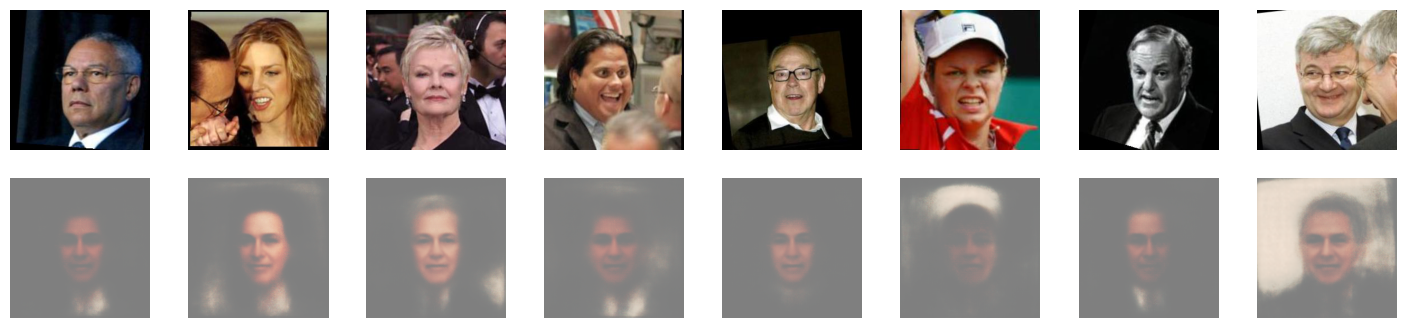

In [116]:
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

vae.apply(initialize_weights)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae.to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-4)  # Reduced learning rate

num_epochs = 10

vae.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device)
        optimizer.zero_grad()
        
        reconstructed_images, mu, logvar = vae(images)

        loss = vae_loss_function(reconstructed_images, images, mu, logvar)
        if not torch.isfinite(loss):
            print(f"Loss is NaN or Inf at epoch {epoch+1}")
            continue  

        loss.backward()
        nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(dataloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

torch.save(vae.state_dict(), 'vae_model.pth')

vae.eval()
with torch.no_grad():
    images, _ = next(iter(dataloader))
    images = images.to(device)
    reconstructed_images, _, _ = vae(images)
    images_to_display = torch.cat((images[:8], reconstructed_images[:8]))  
    images_to_display = images_to_display.cpu().permute(0, 2, 3, 1).numpy()
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(18, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow((images_to_display[i] * 0.5 + 0.5))  
        ax.axis('

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

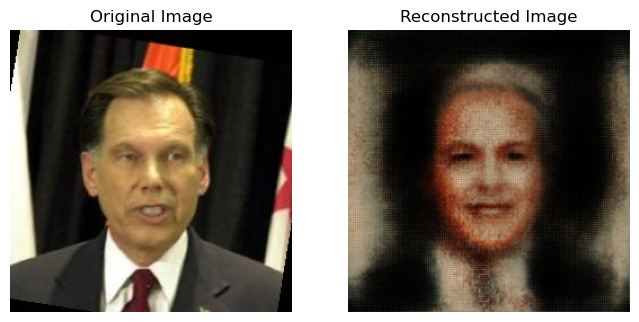

In [129]:
images, _ = next(iter(dataloader))  
image = images[0].unsqueeze(0)  
image = image.to('cuda' if torch.cuda.is_available() else 'cpu')


reconstructed_img, mu, logvar = vae(image)

original_img = image.squeeze(0).detach().cpu()
reconstructed_img = reconstructed_img.squeeze(0).detach().cpu()

original_img_np = original_img.permute(1, 2, 0).numpy()
reconstructed_img_np = reconstructed_img.permute(1, 2, 0).numpy()

original_img_np = original_img_np.clip(0, 1)
reconstructed_img_np = reconstructed_img_np.clip(0, 1)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(original_img_np)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(reconstructed_img_np)
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.show()